In [1]:
import os
import sys
sys.path.append(os.path.join(os.getcwd().replace("large_models", "")))

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from parse_dataset import NetworkDataset, parse_dataset, split_datasets
from model import Model

In [16]:
conf = {
    "batch_size": 516,
    "epochs": 15,
    "learning_rate": 0.0001,
    "load_model": True
}

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
# extract dataset from csv file
network_data_file = os.path.join(os.getcwd().replace("large_models", ""), "datasets", "network_packet_data_test.csv")
data, labels, label_dict = parse_dataset(network_data_file)

# split dataset into train, val and test datasets
X_train, y_train, X_val, y_val, X_test, y_test = split_datasets(data, labels)
print(X_train.shape)
print(y_train.shape)

# create train, val and test dataloaders
train_dataset = NetworkDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=conf["batch_size"], shuffle=True)

val_dataset = NetworkDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=conf["batch_size"], shuffle=True)

test_dataset = NetworkDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=conf["batch_size"])

packet_dat,attack_cat

torch.Size([356334, 513])
torch.Size([356334])


In [6]:
data, labels = next(iter(train_loader))
print(data.shape, labels.shape)

torch.Size([516, 513]) torch.Size([516])


In [7]:
# create LSTM model:
class MLP(nn.Module):
    def __init__(self, size):
        super(MLP, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(size, 320),
            nn.BatchNorm1d(320),
            nn.ReLU(),
            nn.Dropout(p=0.10),

            nn.Linear(320, 24)
        )
    
    def forward(self, x):
        out = self.mlp(x)
        return out

In [8]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.1, alpha=0.9, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

In [ ]:
model = MLP(X_train.shape[1]).to(device)
criterion = FocalLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=conf["learning_rate"], weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.9)

teacher = Model(model, criterion, optimizer, scheduler, device)

if conf["load_model"]:
    # load model
    checkpoint_path = os.path.join(os.getcwd().replace("large_models", ""), "checkpoint", "mlp_model.pth")
    teacher.load(checkpoint_path)

In [12]:
def plot_data(data, type, title, n_epochs=conf["epochs"]):
    epochs = [epoch for epoch in range(1, n_epochs + 1)]
    data = [d.to('cpu') for d in data]
    plt.plot(epochs, data, marker="+", linestyle="dotted")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel(type)
    plt.show()

Epoch: 1/15, Accuracy: 47.48%, Train loss: 1.4265, Val loss: 1.4935
Epoch: 2/15, Accuracy: 64.13%, Train loss: 0.8091, Val loss: 0.9776
Epoch: 3/15, Accuracy: 69.39%, Train loss: 0.6418, Val loss: 0.7708
Epoch: 4/15, Accuracy: 71.99%, Train loss: 0.5352, Val loss: 0.7511
Epoch: 5/15, Accuracy: 74.12%, Train loss: 0.4706, Val loss: 0.6106
Epoch: 6/15, Accuracy: 74.68%, Train loss: 0.4306, Val loss: 0.5853
Epoch: 7/15, Accuracy: 71.51%, Train loss: 0.3949, Val loss: 0.6782
Epoch: 8/15, Accuracy: 78.88%, Train loss: 0.3639, Val loss: 0.4330
Epoch: 9/15, Accuracy: 76.57%, Train loss: 0.3268, Val loss: 0.5044
Epoch: 10/15, Accuracy: 78.68%, Train loss: 0.3087, Val loss: 0.4493
Epoch: 11/15, Accuracy: 76.26%, Train loss: 0.2925, Val loss: 0.5173
Epoch: 12/15, Accuracy: 80.28%, Train loss: 0.2715, Val loss: 0.3948
Epoch: 13/15, Accuracy: 82.52%, Train loss: 0.2629, Val loss: 0.3195
Epoch: 14/15, Accuracy: 83.11%, Train loss: 0.2466, Val loss: 0.3022
Epoch: 15/15, Accuracy: 82.41%, Train loss:

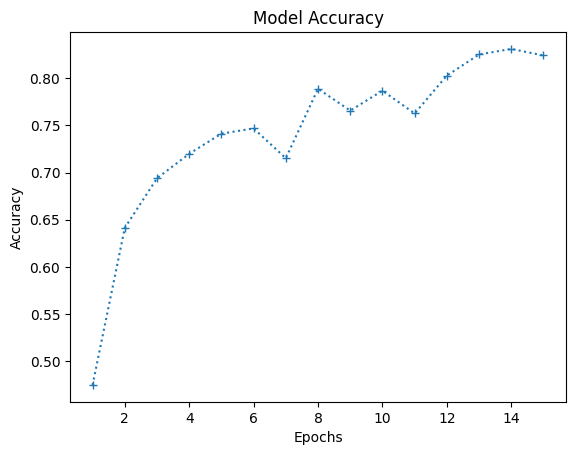

In [13]:
accuracy = []
train_loss = []
val_loss = []

if not conf["load_model"]:
    accuracy, train_loss, val_loss = teacher.train(train_loader=train_loader, val_loader=val_loader, epochs=conf["epochs"])
    plot_data(accuracy, type="Accuracy", title="Model Accuracy")

In [14]:
test_loss, test_acc = teacher.evaluate(test_loader)
print(f"Accuracy: {100*test_acc:.2f}%, Test loss: {test_loss:.4f}")

Accuracy: 82.22%, Test loss: 0.3169


In [15]:
if not conf["load_model"]:
    # load model
    checkpoint_path = os.path.join(os.getcwd().replace("large_models", ""), "checkpoint", "mlp_model.pth")
    teacher.load(checkpoint_path=checkpoint_path)

Checkpoint loaded from /home/jorgetf/testmodel/Network-Packet-ML-Model/checkpoint/mlp_model.pth!
